# Text Classification - IMDB

# Imports 

In [1]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Global vairiables for script

cross_validation_iterations = 30


# Exploring the Dataset

In [3]:
filename = 'SMSSpamData.csv'
SPAM_dataframe = pd.read_csv(filename, encoding='utf-8')

In [4]:
SPAM_dataframe.head()

,class,sms_msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Converting Class Index to int

In [5]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(SPAM_dataframe['class']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later

{'ham': 0, 'spam': 1}


In [6]:
#use the mapping dictionary to transform the class labels into integers

SPAM_dataframe["class"] = SPAM_dataframe["class"].map(class_mapping)


In [7]:
SPAM_dataframe.head()

,class,sms_msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Cleaning up the Data

In [8]:
SPAM_dataframe.loc[42, 'sms_msg']#[-50:]

'07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow'

In [9]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

In [10]:
preprocessor(SPAM_dataframe.loc[42, 'sms_msg'])#[-50:]

'07732584351 rodger burns msg we tried to call you re your reply to our sms for a free nokia mobile free camcorder please call now 08000930705 for delivery tomorrow'

In [11]:
# apply the preprocessor to the entire dataframe (i.e. column review)
SPAM_dataframe['sms_msg'] = SPAM_dataframe['sms_msg'].apply(preprocessor)

# Tokenise, Stemmer & Stop

In [12]:
from nltk.corpus import stopwords 

nltk.download('stopwords')


stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def tokenizer(text):
    text = str(text)
    return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]


def stop_removal(text):
       return [w for w in text if not w in stop]
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
SPAM_dataframe.loc[42, 'sms_msg']

'07732584351 rodger burns msg we tried to call you re your reply to our sms for a free nokia mobile free camcorder please call now 08000930705 for delivery tomorrow'

In [14]:
# SPAM_dataframe_subset = SPAM_dataframe.sample(n=1000)
SPAM_dataframe_subset = SPAM_dataframe

# Training for Sentiment Classification

In [15]:
X_val_train, X_test, y_val_train, y_test = train_test_split(
     SPAM_dataframe_subset.iloc[:,1], SPAM_dataframe_subset.iloc[:,0], test_size=0.20, random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
     X_val_train, y_val_train, test_size=0.20, random_state=42)

In [17]:
print("Number of entries for Training of best models: " + str(len(X_train)))
print("Number of entries for Validating best models: " + str(len(X_val)))
print("Number of entries for Testing best models: " + str(len(X_test)))

Number of entries for Training of best models: 3567
Number of entries for Validating best models: 892
Number of entries for Testing best models: 1115


In [18]:
param_grid0 = [{'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'vect__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
               ]

In [19]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

param_grids = [
    # Logistical Regression Settings
    {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(1, 5, 1)
    },
    # MultinomialNB Settings
    {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__fit_prior': [True, False],
        'clf__alpha': range(1, 5, 1)
    },
    # SVC Settings
    {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(1, 5, 1),
        'clf__kernel': ['rbf', 'linear', 'sigmoid'],
        'clf__gamma': np.arange(0.0, 1.0, 0.1)
    },
    
]

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)


base_models = [LogisticRegression(),
                   MultinomialNB(class_prior = None),
                   SVC()]


# Quicker test settings
param_grids = [
    # Logistical Regression Settings
    {
        'vect__ngram_range': [(1, 1), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(3, 5, 1)
    },
    # MultinomialNB Settings
    {
        'vect__ngram_range': [(1, 1), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__fit_prior': [True, False],
        'clf__alpha': range(3, 6, 1)
    },
    # SVC Settings
    {
        'vect__ngram_range': [(1, 1), (1, 3)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
        'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
        'vect__tokenizer': [tokenizer_stemmer], # use a tokeniser and the stemmer
        'clf__C': range(4, 5, 1),
        'clf__kernel': ['linear', 'sigmoid'],
        'clf__gamma': np.arange(0.5, 0.7, 0.1)
    },
    
]


my_models = []

def testModel(params, model):
    print("Testing: " + model.__class__.__name__)
    
    mnb_tfidf = Pipeline([('vect', tfidf),
                     ('clf',  model)])
                   
    gs_mnb_tfidf = GridSearchCV(mnb_tfidf, params,
                               scoring='accuracy',
                               cv=5, #change to `cross_validation_iterations` if you have lots of time!
                               verbose=1,
                               n_jobs=-1)
    
#     print(sorted(mnb_tfidf.get_params().keys()))
    
    gs_mnb_tfidf.fit(X_val, y_val)
    
         
    clf = gs_mnb_tfidf.best_estimator_
    
    print("Model cv score: " + str(gs_mnb_tfidf.best_score_* 100))
    
    return clf
  
    
    

for item in range(0, len(base_models)):
    best_model = testModel(param_grids[item], base_models[item]) 
    my_models.append((str(base_models[item].__class__.__name__), best_model))
                  
 
    
    
    
print('Best models created!')

Testing: LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.2s finished


Model cv score: 96.0762331838565
Testing: MultinomialNB
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.6s finished


Model cv score: 93.72197309417041
Testing: SVC
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    9.2s finished


Model cv score: 97.86995515695067
Best models created!


In [21]:
print(my_models[0][1].get_params()['vect'])
print(my_models[1][1].get_params()['vect'])
print(my_models[2][1].get_params()['vect'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_stemmer at 0x7f21a0067730>,
        use_idf=True, vocabulary=None)
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={"haven't", 'not', 'all', 'will', 'theirs', 'haven', 'no', 'm', 'them', 'yourself', 'own', 'him', 'than', 'can', 'a', 'such', 'or', 'very', 'each', 'ain', 'our', 'the', 'were', 'during', 'from', 'out', 

### Settings found to be good
if you do not have time to test paramiters, settings bellow have found to be good for SMS prediction:
```
LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
MultinomialNB(alpha=1, class_prior=None, fit_prior=False)
SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)```

In [22]:
results = []
names = []
roc_prediction = []
for name, model in my_models:
    print('---------------------------------')
    print('Cross validation of model: ' + name + ' with settings: \n')
    print(str(model.get_params()['clf']) + '\n')
    
    cv = ShuffleSplit(n_splits=cross_validation_iterations, test_size=0.2, random_state=42)
    
    cv_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                 cv=cv, scoring='accuracy',
                                                 verbose=1,
                                                 n_jobs=-1)
    roc_prediction.append(model.predict(X_test))
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    print('---------------------------------')
    print('Complete')
    

---------------------------------
Cross validation of model: LogisticRegression with settings: 

LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.5s finished


[0.98179272 0.98179272 0.99159664 0.98739496 0.98739496 0.99159664
 0.97619048 0.97759104 0.98039216 0.97759104 0.9859944  0.99019608
 0.9859944  0.98739496 0.98459384 0.98319328 0.98739496 0.97759104
 0.98179272 0.98039216 0.9859944  0.98459384 0.98459384 0.98459384
 0.98179272 0.98179272 0.9789916  0.98179272 0.97619048 0.98179272]
---------------------------------
Complete
---------------------------------
Cross validation of model: MultinomialNB with settings: 

MultinomialNB(alpha=3, class_prior=None, fit_prior=False)



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.2s finished


[0.97058824 0.97058824 0.9789916  0.97759104 0.97478992 0.9789916
 0.97338936 0.97058824 0.97058824 0.97338936 0.96778711 0.9859944
 0.97058824 0.97759104 0.97058824 0.97058824 0.9789916  0.96778711
 0.9719888  0.97058824 0.96918768 0.98039216 0.9719888  0.9789916
 0.97619048 0.97759104 0.97058824 0.97619048 0.96498599 0.97058824]
---------------------------------
Complete
---------------------------------
Cross validation of model: SVC with settings: 

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.6s finished


[0.98739496 0.98739496 0.99019608 0.99159664 0.99019608 0.9929972
 0.9859944  0.98459384 0.98879552 0.98039216 0.98879552 0.99439776
 0.99019608 0.98879552 0.98879552 0.9859944  0.98739496 0.98459384
 0.98739496 0.98739496 0.98879552 0.98879552 0.9859944  0.98879552
 0.98879552 0.98319328 0.9859944  0.98459384 0.98459384 0.99019608]
---------------------------------
Complete


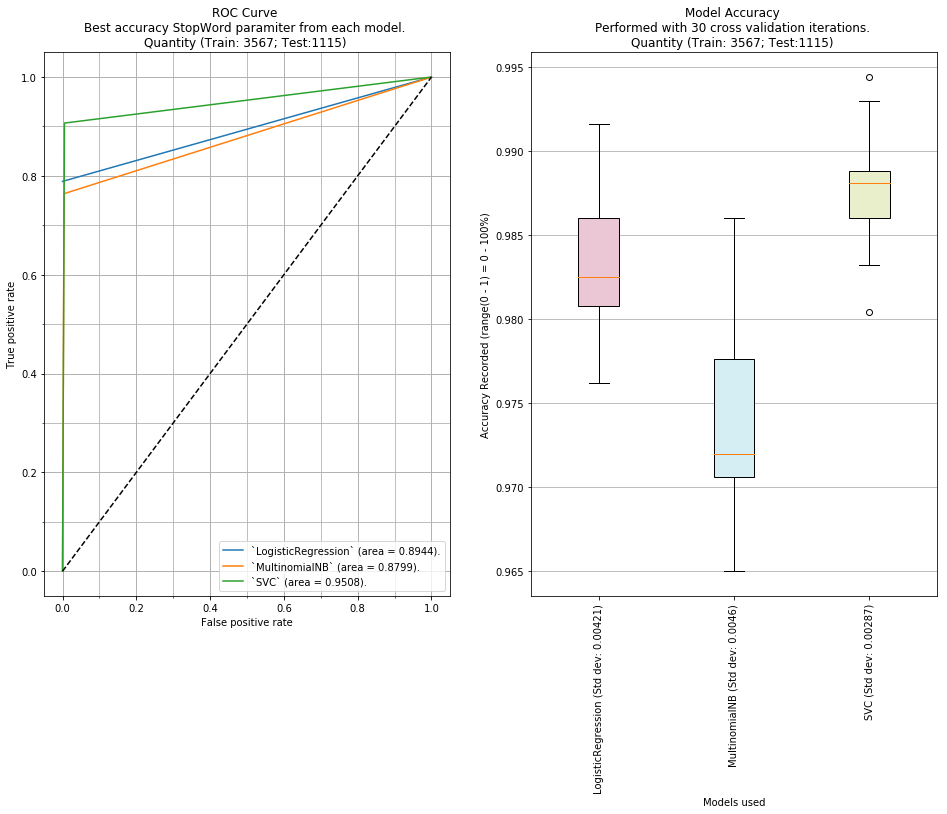

In [48]:
from matplotlib.ticker import MultipleLocator
from math import *
from statistics import *

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

for result in range(0, len(results)):
    fpr, tpr, threshold = roc_curve(y_test, roc_prediction[result]) 

# This is the AUC
    the_auc = auc(fpr, tpr)
# This is the ROC curve

    plot_label = "`" + names[result] + "` (area = "+str(round(the_auc, 4))+")."
    
    axes[0].plot(fpr,tpr, label=plot_label)

axes[0].plot([0, 1], [0, 1], 'k--') # diagonal    

axes[0].set_title('ROC Curve \n'+
                  'Best accuracy StopWord paramiter from each model. \n' +
                 'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend(loc='best')
axes[0].xaxis.grid(True)

spacing = 0.1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)

axes[0].yaxis.set_minor_locator(minorLocator)
axes[0].xaxis.set_minor_locator(minorLocator)
axes[0].grid(which = 'minor')


# box plot

sd_labels = []

for plot_name in range(0, len(results)):
    sd_labels.append(names[plot_name] + " (Std dev: " + str(round(results[plot_name].std(), 5)) + ")")


bplot2 = axes[1].boxplot(results,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=sd_labels
                         )  # will be used to label x-ticks
axes[1].set_title('Model Accuracy \n'+ 
                  'Performed with ' + str(cross_validation_iterations) +' cross validation iterations. \n' + 
                  'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')

axes[1].set_xlabel('Models used')
axes[1].set_ylabel('Accuracy Recorded (range(0 - 1) = 0 - 100%)')

# fill with colors
colors = ['#EBC7D5', '#D4EEF4', '#E9EFCA']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)

    
    
plt.xticks(rotation=90)
plt.show()

In [52]:
print("Mean values")
for result in range(0, len(results)):
    print(str(names[result])+ ": " +str(round(results[result].mean()*100,2)) + "%")

Mean values
LogisticRegression: 98.33%
MultinomialNB: 97.36%
SVC: 98.78%


In [53]:
print("Max values")
for result in range(0, len(results)):
    print(str(names[result])+ ": " +str(round(results[result].max()*100,2)) + "%")

Max values
LogisticRegression: 99.16%
MultinomialNB: 98.6%
SVC: 99.44%


In [54]:
print("Standard Deviation")
for result in range(0, len(results)):
    print(str(names[result])+ ": " +str(round(results[result].std()*100,2)) + "%")

Standard Deviation
LogisticRegression: 0.42%
MultinomialNB: 0.46%
SVC: 0.29%
